# Part II: Investigating the Vanishing Gradient Problem [20 pts]
Experimentally demonstrate the vanishing gradient problem in deep CNNs and understand how ResNet's architecture mitigates it. You will also explore other key CNN concepts through additional experiments.

In [1]:
import os
import torch
from torchvision import datasets, transforms
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Subset
from torchsummary import summary

In [2]:
!unzip cnn_dataset.zip -d /content/cnn_dataset/
dataset_path = "/content/cnn_dataset"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
class_names = dataset.classes
class_counts = Counter([dataset.targets[i] for i in range(len(dataset))])
df = pd.DataFrame({'Class': class_names, 'Image Count': [class_counts[i] for i in range(len(class_names))]})
print(f"Total Images: {len(dataset)}")
print(f"Number of Classes: {len(class_names)}")
print("\nClass Distribution:\n", df)

Streaming output truncated to the last 5000 lines.
  inflating: /content/cnn_dataset/vehicles/5505.jpg  
  inflating: /content/cnn_dataset/vehicles/5506.jpg  
  inflating: /content/cnn_dataset/vehicles/5507.jpg  
  inflating: /content/cnn_dataset/vehicles/5508.jpg  
  inflating: /content/cnn_dataset/vehicles/5509.jpg  
  inflating: /content/cnn_dataset/vehicles/551.jpg  
  inflating: /content/cnn_dataset/vehicles/5510.jpg  
  inflating: /content/cnn_dataset/vehicles/5511.jpg  
  inflating: /content/cnn_dataset/vehicles/5512.jpg  
  inflating: /content/cnn_dataset/vehicles/5513.jpg  
  inflating: /content/cnn_dataset/vehicles/5514.jpg  
  inflating: /content/cnn_dataset/vehicles/5515.jpg  
  inflating: /content/cnn_dataset/vehicles/5516.jpg  
  inflating: /content/cnn_dataset/vehicles/5517.jpg  
  inflating: /content/cnn_dataset/vehicles/5518.jpg  
  inflating: /content/cnn_dataset/vehicles/5519.jpg  
  inflating: /content/cnn_dataset/vehicles/552.jpg  
  inflating: /content/cnn_dataset

In [3]:
targets = torch.LongTensor(dataset.targets)

In [4]:
indices = np.arange(len(dataset))
train_idx, test_val_idx = train_test_split(indices, test_size=0.3, stratify=dataset.targets, random_state=42)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5, stratify=[dataset.targets[i] for i in test_val_idx], random_state=42)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Training set: 21000 images
Validation set: 4500 images
Test set: 4500 images


## Step 1: Create a deeper version of your VGG-16 network (VGG-Deep)

In [36]:
class VGG_Deep_model(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG_Deep_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [37]:
iteration_counter = 0
grad_norms_dict = {}

In [38]:
def gradient_hook(module, grad_input, grad_output):
    global iteration_counter, grad_norms_dict
    if iteration_counter % 10 == 0:
        if module.weight.grad is not None:
            norm_value = module.weight.grad.clone().detach().norm(p=2).item()
        else:
            norm_value = 0.0
        grad_norms_dict[module.layer_id].append((iteration_counter, norm_value))


In [39]:
def grad_hook_method(grad, layer_id):
    global iteration_counter, grad_norms_dict
    if iteration_counter % 10 == 0:
        norm_value = grad.detach().clone().norm(p=2).item()
        grad_norms_dict[layer_id].append((iteration_counter, norm_value))
    return grad

In [40]:
def register_gradient_hooks(model):
    global grad_norms_dict
    layer_idx = 0

    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            module.layer_id = f"conv_{layer_idx}"
            grad_norms_dict[module.layer_id] = []
            module.weight.register_hook(lambda grad, layer_id=module.layer_id: grad_hook_method(grad, layer_id))
            layer_idx += 1

## Step 2: Training VGG-Deep

In [41]:
def kaiming(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [42]:
def run_an_epoch(model, dataloader, criterion, optimizer, device):
    global iteration_counter
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        iteration_counter += 1

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [43]:
def evaluate_an_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

<span style='color:green'>### YOUR ANSWER ###</span>

In [44]:
def train_function(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        train_loss, train_acc = run_an_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate_an_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n")
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}\n")
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [45]:
def plot_training_graphs(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, title=''):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [46]:
def test_function(model, test_loader, device):
    model.eval()
    running_corrects = 0

    with torch.no_grad():

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

In [47]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

Training VGG-Deep (deeper network without dropout/regularization)
Using device: cuda
Epoch 1/10
----------
Train Loss: 0.7867 Acc: 0.6562
Val   Loss: 0.5712 Acc: 0.7778

Epoch 2/10
----------
Train Loss: 0.4899 Acc: 0.7991
Val   Loss: 0.6936 Acc: 0.7204

Epoch 3/10
----------
Train Loss: 0.4203 Acc: 0.8356
Val   Loss: 0.4193 Acc: 0.8293

Epoch 4/10
----------
Train Loss: 0.3648 Acc: 0.8598
Val   Loss: 0.3831 Acc: 0.8536

Epoch 5/10
----------
Train Loss: 0.3213 Acc: 0.8758
Val   Loss: 0.3632 Acc: 0.8593

Epoch 6/10
----------
Train Loss: 0.2906 Acc: 0.8909
Val   Loss: 0.3319 Acc: 0.8729

Epoch 7/10
----------
Train Loss: 0.2617 Acc: 0.9000
Val   Loss: 0.3353 Acc: 0.8729

Epoch 8/10
----------
Train Loss: 0.2390 Acc: 0.9093
Val   Loss: 0.6652 Acc: 0.7416

Epoch 9/10
----------
Train Loss: 0.2145 Acc: 0.9196
Val   Loss: 0.3703 Acc: 0.8738

Epoch 10/10
----------
Train Loss: 0.1907 Acc: 0.9297
Val   Loss: 0.3368 Acc: 0.8771

Training complete in 23m 8s
Best val Acc: 0.8771



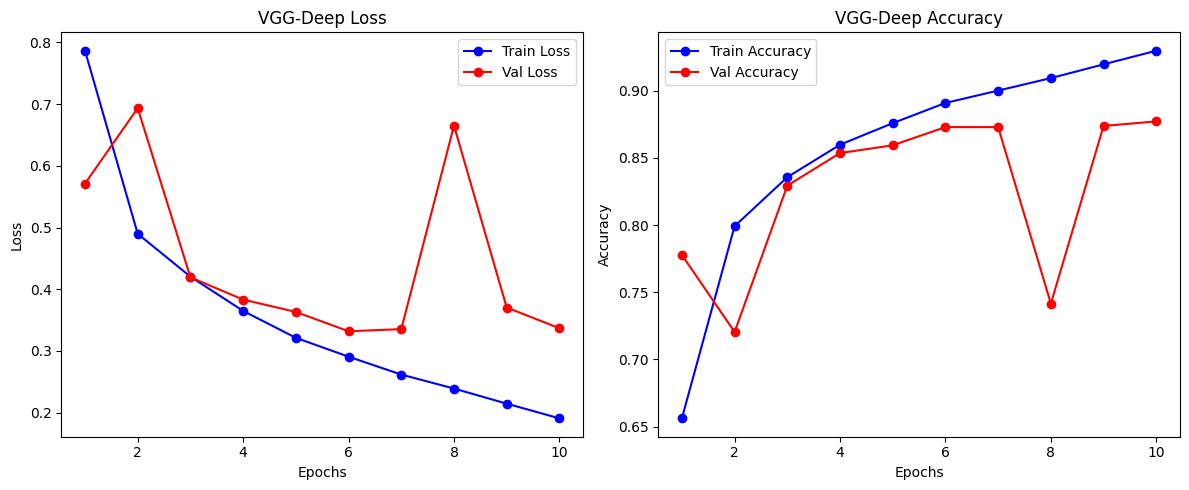

Test Accuracy: 0.8920
Test Accuracy (VGG-Deep): 0.8920


In [48]:
print("=" * 60)
print("Training VGG-Deep (deeper network without dropout/regularization)")
print("=" * 60)
iteration_counter = 0
grad_norms_dict = {}
num_classes = len(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
b_size = 32
train_loader, val_loader, test_loader = create_dataloaders(b_size)
deep_model = VGG_Deep_model(num_classes=num_classes).to(device)
deep_model.apply(kaiming)
register_gradient_hooks(deep_model)
criterion_deep = nn.CrossEntropyLoss()
optimizer_deep = optim.SGD(deep_model.parameters(), lr=0.01)
start_time = time.time()
trained_model_deep, train_losses_deep, train_accuracies_deep, val_losses_deep, val_accuracies_deep = train_function(
    deep_model, train_loader, val_loader, criterion_deep, optimizer_deep, device, num_epochs=10)
plot_training_graphs(train_losses_deep, val_losses_deep, train_accuracies_deep, val_accuracies_deep, num_epochs=10,
                     title='VGG-Deep')
test_acc_deep = test_function(trained_model_deep, test_loader, device)
print(f"Test Accuracy (VGG-Deep): {test_acc_deep:.4f}")

In [49]:
print(train_accuracies_deep)
print(train_losses_deep)
print(val_accuracies_deep)
print(val_losses_deep)

[0.6561904761904762, 0.7991428571428572, 0.8356190476190476, 0.8597619047619048, 0.8758095238095238, 0.8908571428571429, 0.9000476190476191, 0.9093333333333333, 0.9195714285714286, 0.9297142857142857]
[0.7866815330301012, 0.48988118151256016, 0.4203482119355883, 0.3648358455669312, 0.3212558316276187, 0.2906429291253998, 0.2616575629171871, 0.23900049626543407, 0.21448946559996832, 0.190692070395464]
[0.7777777777777778, 0.7204444444444444, 0.8293333333333334, 0.8535555555555556, 0.8593333333333334, 0.8728888888888889, 0.8728888888888889, 0.7415555555555556, 0.8737777777777778, 0.8771111111111112]
[0.5712489724689059, 0.693595696290334, 0.4193099621136983, 0.3831499393516117, 0.36317828183703954, 0.3318519252936045, 0.3353147709634569, 0.6652361934449937, 0.37031800553533767, 0.3367774153020647]


## Step 3: Gradient analysis

- Track the average L2 norm of the gradients in each convolutional layer using PyTorch hooks.

Create a separate plot showing the gradient norms for a subset of layers.

- Create a plot showing the average gradient norm for each convolutional layer over time.

In [50]:
def plot_norms(grad_norms_dict):
    plt.figure(figsize=(12, 6))

    for layer_id, data in grad_norms_dict.items():
        if data:
            iterations, norms = zip(*data)
            plt.plot(iterations, norms, label=layer_id)

    plt.xlabel("Iteration")
    plt.ylabel("Gradient L2 Norm")
    plt.title("Gradient Norms for All Convolutional Layers")
    plt.legend()
    plt.show()
    selected_layers = []
    keys = sorted(grad_norms_dict.keys(), key=lambda x: int(x.split('_')[1]))
    if len(keys) > 0:
        if len(keys) > 1:
            selected_layers.append(keys[1])
        if len(keys) > 4:
            selected_layers.append(keys[4])
        if len(keys) > 7:
            selected_layers.append(keys[7])
        selected_layers.append(keys[-1])
    plt.figure(figsize=(12, 6))

    for layer_id in selected_layers:
        data = grad_norms_dict[layer_id]
        if data:
            iterations, norms = zip(*data)
            plt.plot(iterations, norms, label=layer_id)

    plt.xlabel("Iteration")
    plt.ylabel("Gradient L2 Norm")
    plt.title("Gradient Norms for Selected Convolutional Layers")
    plt.legend()
    plt.show()


Plotting Gradient Norms for VGG-Deep...


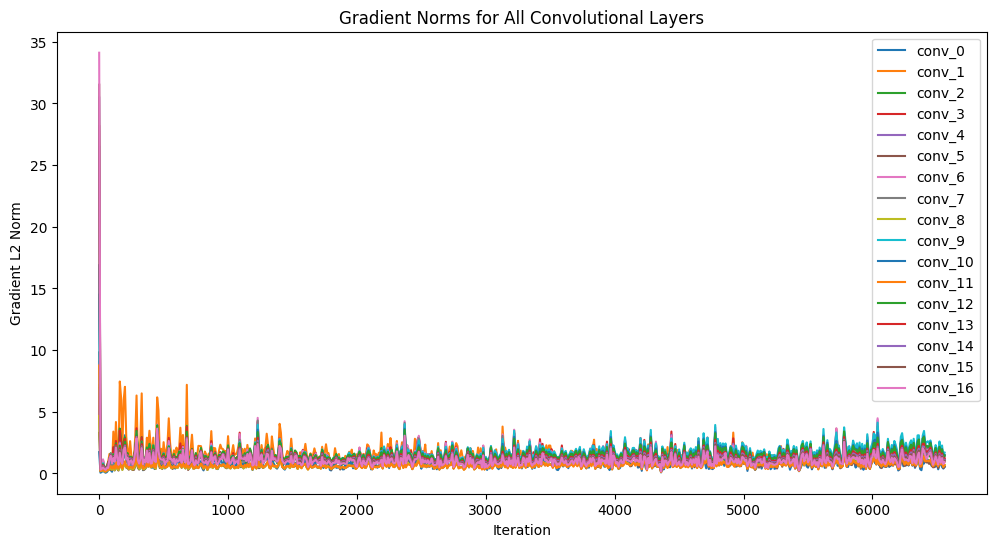

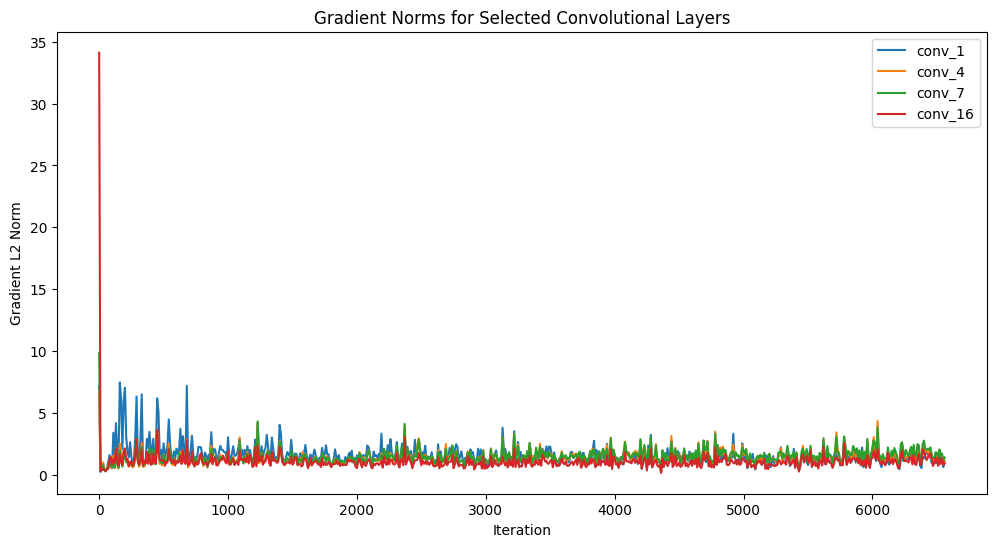

In [51]:
print("\nPlotting Gradient Norms for VGG-Deep...")
plot_norms(grad_norms_dict)

## Step 4: Comparison with VGG-16 and ResNet-18

- Compare the training curves (loss and accuracy vs. epoch) of VGG-Deep, VGG-16, and ResNet-18.

In [52]:
train_loss_res = [0.6814667278698513,
  0.5743110807396117,
  0.5504688636234828,
  0.5141196505682809,
  0.5025241153353737,
  0.4892336047717503,
  0.4908684737909408,
  0.4539867091973623,
  0.4585125615596771,
  0.43787543687366304,
  0.3975911409514291,
  0.397602581347738]

train_acc_res = [0.573047619047619,
  0.6126666666666667,
  0.637095238095238,
  0.6239523809523809,
  0.6432857142857142,
  0.641095238095238,
  0.6574761904761904,
  0.6531428571428571,
  0.6496666666666666,
  0.6504761904761904,
  0.6735714285714286,
  0.6450476190476191]

val_loss_res = [0.44454012192620174,
  0.36356124716334876,
  0.2815040718317032,
  0.2537566509114371,
  0.23151912132898966,
  0.25916093368000453,
  0.2872505743238661,
  0.2159846739239163,
  0.2539200418525272,
  0.22453344265619915,
  0.16899959054258135,
  0.18179676936732397]

val_acc_res = [0.856,
  0.8755555555555555,
  0.9011111111111111,
  0.924,
  0.9235555555555556,
  0.9164444444444444,
  0.9331111111111111,
  0.9364444444444444,
  0.9122222222222223,
  0.9357777777777778,
  0.9573333333333334,
  0.9553333333333334]

train_loss_vgg = [0.7755079404058911, 0.5064942116623833, 0.41907461838495164, 0.361461782909575, 0.31463205218315127, 0.2837349299788475, 0.2520964642649605, 0.23336114595617566, 0.2031063601516542, 0.1801866364308766]
train_accs_vgg = [0.6361904761904762, 0.8004761904761905, 0.8382857142857143, 0.8608095238095238, 0.8822380952380953, 0.8918095238095238, 0.9047142857142857, 0.9118095238095238, 0.923, 0.9343809523809524]
val_loss_vgg = [0.5076592330932617, 0.4269339513513777, 0.37907193125618827, 0.3163323191271888, 0.2964695050186581, 0.2784410022629632, 0.3436990509298113, 0.2579884813692835, 0.3171757252679931, 0.2584740707145797]
val_accs_vgg = [0.7993333333333333, 0.8266666666666667, 0.864, 0.8822222222222222, 0.8842222222222222, 0.8924444444444445, 0.8755555555555556, 0.9051111111111112, 0.8851111111111112, 0.904888888888889]


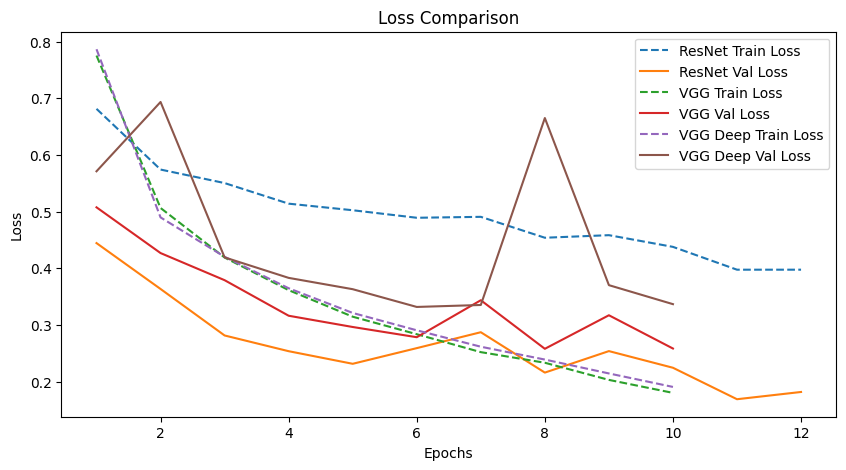

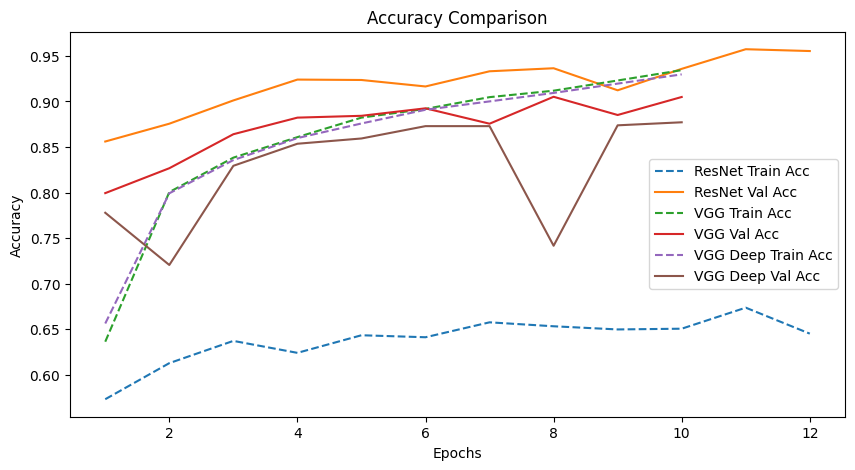

In [53]:
epochs_res_vgg = range(1, len(train_loss_res) + 1)
epochs_vgg = range(1, len(train_loss_vgg) + 1)
epochs_model3 = range(1, len(train_losses_deep) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_res_vgg, train_loss_res, label='ResNet Train Loss', linestyle='dashed')
plt.plot(epochs_res_vgg, val_loss_res, label='ResNet Val Loss')
plt.plot(epochs_vgg, train_loss_vgg, label='VGG Train Loss', linestyle='dashed')
plt.plot(epochs_vgg, val_loss_vgg, label='VGG Val Loss')
plt.plot(epochs_model3, train_losses_deep, label='VGG Deep Train Loss', linestyle='dashed')
plt.plot(epochs_model3, val_losses_deep, label='VGG Deep Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs_res_vgg, train_acc_res, label='ResNet Train Acc', linestyle='dashed')
plt.plot(epochs_res_vgg, val_acc_res, label='ResNet Val Acc')
plt.plot(epochs_vgg, train_accs_vgg, label='VGG Train Acc', linestyle='dashed')
plt.plot(epochs_vgg, val_accs_vgg, label='VGG Val Acc')
plt.plot(epochs_model3, train_accuracies_deep, label='VGG Deep Train Acc', linestyle='dashed')
plt.plot(epochs_model3, val_accuracies_deep, label='VGG Deep Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.show()

- Discuss how ResNet’s residual connections impact the gradient flow compared to VGG-Deep.

ResNet’s residual connections significantly improve the flow of gradients during training, making deep networks more efficient compared to architectures like VGG. One of the biggest challenges in training deep networks is the vanishing gradient problem, where gradients become extremely small as they move backward through many layers. This can slow down learning and make it difficult for earlier layers to update their weights effectively. VGG, being a very deep network, suffers from this issue, making training unstable without special techniques like batch normalization or careful weight initialization.

ResNet addresses this challenge using skip connections, which allow information to bypass certain layers instead of passing through every transformation. Instead of learning the full transformation of an input, ResNet learns the difference (residual) between the input and output. Mathematically, this is expressed as:

y=F(x)+x
where
x is the original input passed forward unchanged, and

F(x) represents the transformations applied by convolutional layers. By directly adding the input back to the output, ResNet ensures that gradients have a clear, unobstructed path during backpropagation, preventing them from shrinking too much as they move through the network.

This approach leads to more stable and efficient training. In VGG, gradients must pass through every layer, making it difficult for very deep networks to learn effectively. However, in ResNet, the shortcut connections allow gradients to take shorter paths, ensuring that earlier layers continue to receive meaningful updates. This enables training of networks with hundreds of layers (e.g., ResNet-50, ResNet-101, ResNet-152) without suffering from significant performance drops, unlike VGG, which struggles with depth beyond a certain point.

Overall, ResNet outperforms VGG in both accuracy and efficiency, especially on large datasets like ImageNet. Its design allows deep networks to be trained faster and more effectively without requiring extensive hyperparameter tuning. By overcoming the limitations of traditional deep architectures, ResNet has set a new standard for training deep neural networks, making it one of the most widely used architectures in modern computer vision tasks.

## Step 5: Investigate and analyze more setups

- Select any THREE experiments to investigate and analyze.

### Experiment 1

In [21]:
def train_an_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [22]:
def validate_an_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [23]:
def train_the_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_an_epoch(model, train_loader, criterion, optimizer, device)
        scheduler.step()
        val_loss, val_acc = validate_an_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}  Acc: {val_acc:.4f}\n")
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}\n")
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [24]:
def test_the_model(model, test_loader, device):
    model.eval()
    running_corrects = 0

    with torch.no_grad():

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

In [25]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, title=''):
    epochs = range(1, num_epochs+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Acc')
    plt.plot(epochs, val_accuracies, 'ro-', label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [26]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [27]:
class Small_VGG_model(nn.Module):
    def __init__(self, kernel_size=3, num_classes=3):
        super(Small_VGG_model, self).__init__()
        padding = (kernel_size - 1) // 2
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [28]:
train_loader, val_loader, test_loader = create_dataloaders(b_size)

Using device: cuda
Experiment a: Impact of Kernel Size

Training SmallVGG with 3x3 kernels
Epoch 1/10
Train Loss: 0.6196  Acc: 0.7430
Val   Loss: 0.5130  Acc: 0.7778

Epoch 2/10
Train Loss: 0.4401  Acc: 0.8253
Val   Loss: 0.4063  Acc: 0.8373

Epoch 3/10
Train Loss: 0.3647  Acc: 0.8602
Val   Loss: 0.3361  Acc: 0.8744

Epoch 4/10
Train Loss: 0.3179  Acc: 0.8784
Val   Loss: 0.3420  Acc: 0.8667

Epoch 5/10
Train Loss: 0.2959  Acc: 0.8861
Val   Loss: 0.3058  Acc: 0.8822

Epoch 6/10
Train Loss: 0.2410  Acc: 0.9094
Val   Loss: 0.2677  Acc: 0.9009

Epoch 7/10
Train Loss: 0.2290  Acc: 0.9149
Val   Loss: 0.2656  Acc: 0.9042

Epoch 8/10
Train Loss: 0.2256  Acc: 0.9159
Val   Loss: 0.2666  Acc: 0.8993

Epoch 9/10
Train Loss: 0.2209  Acc: 0.9186
Val   Loss: 0.2620  Acc: 0.9042

Epoch 10/10
Train Loss: 0.2164  Acc: 0.9202
Val   Loss: 0.2680  Acc: 0.9009

Training complete in 3m 56s
Best val Acc: 0.9042

Test Accuracy: 0.9104


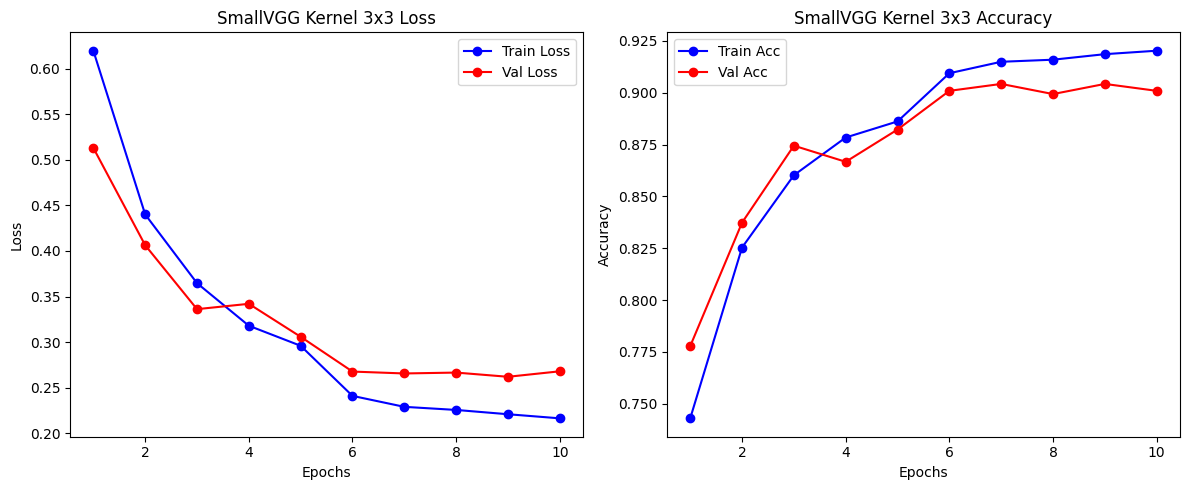


Training SmallVGG with 5x5 kernels
Epoch 1/10
Train Loss: 0.6197  Acc: 0.7412
Val   Loss: 0.4550  Acc: 0.8258

Epoch 2/10
Train Loss: 0.4156  Acc: 0.8354
Val   Loss: 0.3686  Acc: 0.8609

Epoch 3/10
Train Loss: 0.3535  Acc: 0.8636
Val   Loss: 0.3659  Acc: 0.8582

Epoch 4/10
Train Loss: 0.3120  Acc: 0.8819
Val   Loss: 0.4125  Acc: 0.8473

Epoch 5/10
Train Loss: 0.2815  Acc: 0.8942
Val   Loss: 0.3299  Acc: 0.8787

Epoch 6/10
Train Loss: 0.2196  Acc: 0.9185
Val   Loss: 0.2545  Acc: 0.9031

Epoch 7/10
Train Loss: 0.2057  Acc: 0.9233
Val   Loss: 0.2486  Acc: 0.9049

Epoch 8/10
Train Loss: 0.1998  Acc: 0.9260
Val   Loss: 0.2493  Acc: 0.9056

Epoch 9/10
Train Loss: 0.1956  Acc: 0.9267
Val   Loss: 0.2472  Acc: 0.9071

Epoch 10/10
Train Loss: 0.1897  Acc: 0.9290
Val   Loss: 0.2405  Acc: 0.9102

Training complete in 4m 39s
Best val Acc: 0.9102

Test Accuracy: 0.9180


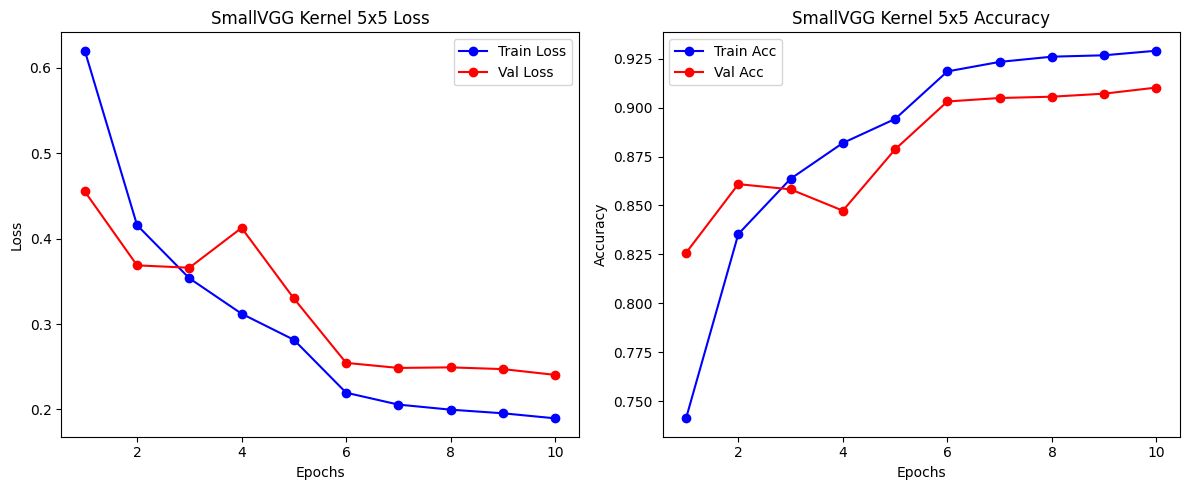


Training SmallVGG with 7x7 kernels
Epoch 1/10
Train Loss: 0.6618  Acc: 0.7182
Val   Loss: 0.4472  Acc: 0.8264

Epoch 2/10
Train Loss: 0.4208  Acc: 0.8346
Val   Loss: 0.4691  Acc: 0.8167

Epoch 3/10
Train Loss: 0.3577  Acc: 0.8642
Val   Loss: 0.3751  Acc: 0.8571

Epoch 4/10
Train Loss: 0.3174  Acc: 0.8782
Val   Loss: 0.3945  Acc: 0.8422

Epoch 5/10
Train Loss: 0.2878  Acc: 0.8904
Val   Loss: 0.3734  Acc: 0.8627

Epoch 6/10
Train Loss: 0.2261  Acc: 0.9153
Val   Loss: 0.2616  Acc: 0.8984

Epoch 7/10
Train Loss: 0.2127  Acc: 0.9206
Val   Loss: 0.2640  Acc: 0.8956

Epoch 8/10
Train Loss: 0.2036  Acc: 0.9244
Val   Loss: 0.2574  Acc: 0.8982

Epoch 9/10
Train Loss: 0.1983  Acc: 0.9258
Val   Loss: 0.2489  Acc: 0.9062

Epoch 10/10
Train Loss: 0.1938  Acc: 0.9278
Val   Loss: 0.2677  Acc: 0.8973

Training complete in 6m 33s
Best val Acc: 0.9062

Test Accuracy: 0.9107


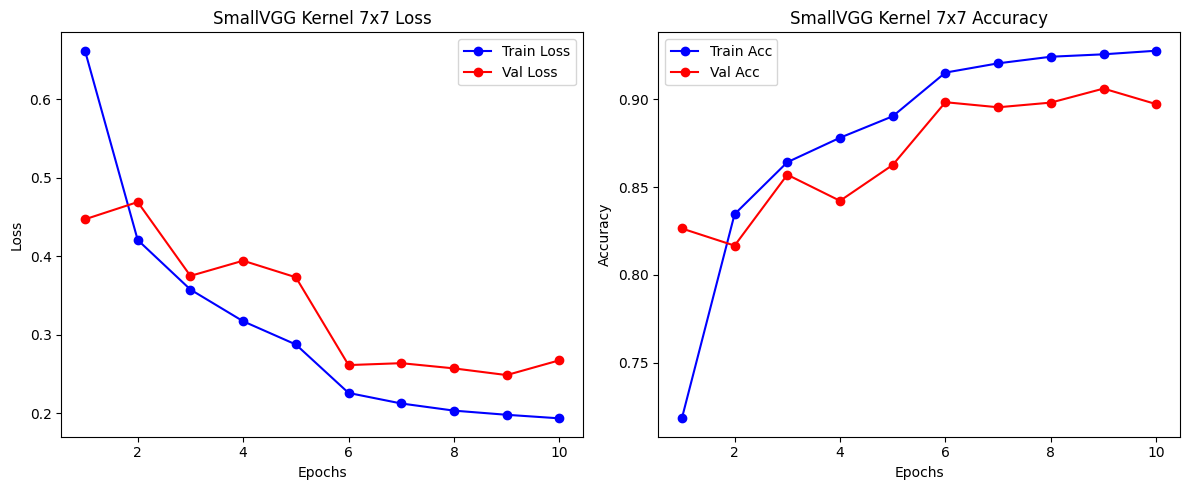

Kernel Size Experiment Results: {'kernel_3': 0.9104444444444445, 'kernel_5': 0.918, 'kernel_7': 0.9106666666666667}


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)
print("="*60)
print("Experiment a: Impact of Kernel Size")
print("="*60)
models_kernel = {}

for k in [3, 5, 7]:
    print(f"\nTraining SmallVGG with {k}x{k} kernels")
    model_k = Small_VGG_model(kernel_size=k, num_classes=num_classes).to(device)
    model_k.apply(kaiming)
    optimizer_k = optim.SGD(model_k.parameters(), lr=0.01, momentum=0.9)
    scheduler_k = lr_scheduler.StepLR(optimizer_k, step_size=5, gamma=0.1)
    model_k, train_losses_k, train_accs_k, val_losses_k, val_accs_k = train_the_model(
        model_k, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_k, scheduler_k, device, num_epochs=10)
    test_acc_k = test_the_model(model_k, test_loader, device)
    models_kernel[f'kernel_{k}'] = test_acc_k.item()
    plot_training_curves(train_losses_k, val_losses_k, train_accs_k, val_accs_k, num_epochs=10,
                         title=f'SmallVGG Kernel {k}x{k}')
print("Kernel Size Experiment Results:", models_kernel)

### How Kernel Size Affects Performance:<br>
Kernel size plays a crucial role in how a neural network processes images. Smaller kernels like 3×3 focus on fine details and textures, making them good for capturing sharp edges and small patterns. However, they may struggle to recognize larger structures within an image. On the other hand, larger kernels like 7×7 capture broader patterns and spatial relationships but can sometimes smooth out finer details, leading to a loss of important information.<br>

### Why the 5×5 Kernel Performed Best:<br>
The 5×5 kernel seems to have struck the right balance between these two extremes. It is large enough to capture important patterns beyond just fine details but not so large that it overly smooths or generalizes the image features. This explains why it achieved the highest accuracy, as it provided a good mix of local and global feature extraction.

### Experiment 2

In [30]:
class Small_VGG_model_with_1x1(nn.Module):
    def __init__(self, num_classes=3):
        super(Small_VGG_model_with_1x1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class Small_VGG_model_without_1x1(nn.Module):
    def __init__(self, num_classes=3):
        super(Small_VGG_model_without_1x1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



Experiment b: Impact of 1x1 Convolutions

Training model WITH 1x1 convolutions
Epoch 1/10
Train Loss: 0.6249  Acc: 0.7328
Val   Loss: 0.6497  Acc: 0.7322

Epoch 2/10
Train Loss: 0.4524  Acc: 0.8210
Val   Loss: 0.3995  Acc: 0.8464

Epoch 3/10
Train Loss: 0.3904  Acc: 0.8477
Val   Loss: 0.3644  Acc: 0.8631

Epoch 4/10
Train Loss: 0.3589  Acc: 0.8578
Val   Loss: 0.3720  Acc: 0.8538

Epoch 5/10
Train Loss: 0.3410  Acc: 0.8671
Val   Loss: 0.3859  Acc: 0.8476

Epoch 6/10
Train Loss: 0.2833  Acc: 0.8915
Val   Loss: 0.2993  Acc: 0.8871

Epoch 7/10
Train Loss: 0.2746  Acc: 0.8937
Val   Loss: 0.2967  Acc: 0.8878

Epoch 8/10
Train Loss: 0.2691  Acc: 0.8958
Val   Loss: 0.2970  Acc: 0.8873

Epoch 9/10
Train Loss: 0.2642  Acc: 0.8989
Val   Loss: 0.2908  Acc: 0.8927

Epoch 10/10
Train Loss: 0.2595  Acc: 0.9013
Val   Loss: 0.2908  Acc: 0.8913

Training complete in 4m 1s
Best val Acc: 0.8927

Test Accuracy: 0.9007


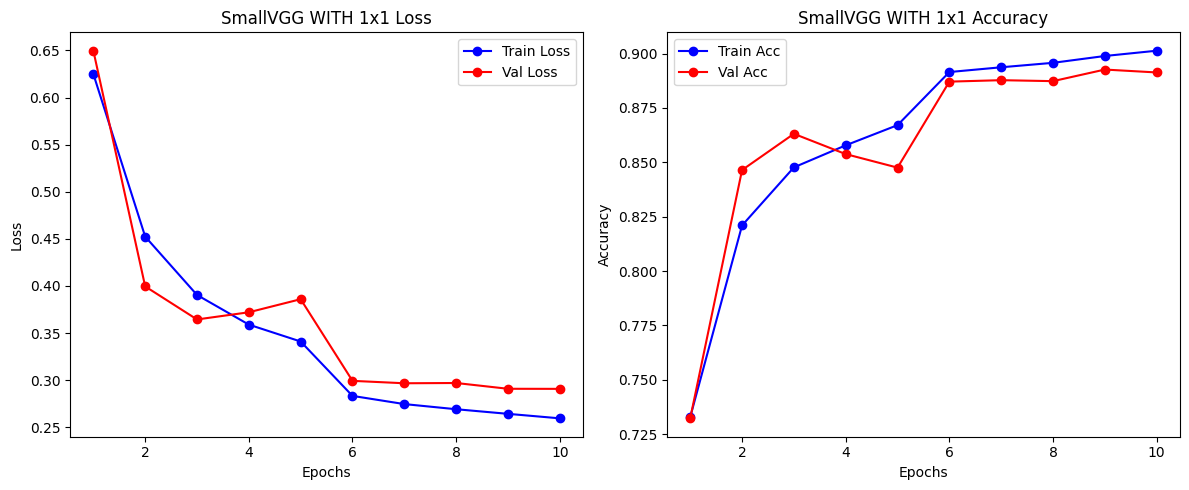


Parameter count for model WITH 1x1:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           1,056
              ReLU-4         [-1, 32, 128, 128]               0
         MaxPool2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
 AdaptiveAvgPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 128]         131,200
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 3]             387
Total params: 152,035
Trainable params: 152,035
Non-trainable para

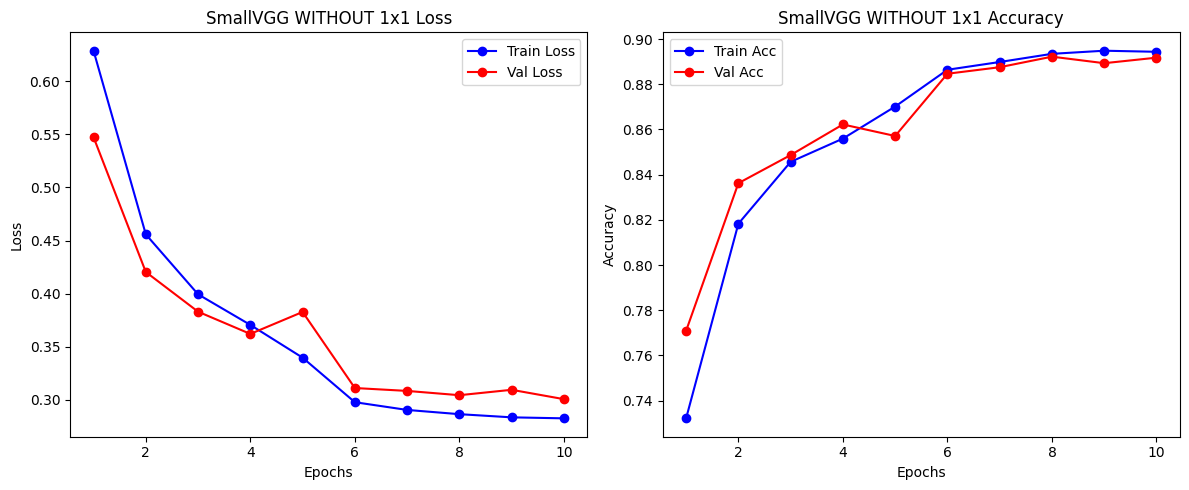


Parameter count for model WITHOUT 1x1:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 64, 4, 4]               0
            Linear-8                  [-1, 128]         131,200
              ReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 3]             387
Total params: 150,979
Trainable params: 150,979
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB):

In [31]:
print("\n" + "="*60)
print("Experiment b: Impact of 1x1 Convolutions")
print("="*60)
print("\nTraining model WITH 1x1 convolutions")
model_with_1x1 = Small_VGG_model_with_1x1(num_classes=num_classes).to(device)
model_with_1x1.apply(kaiming)
optimizer_with = optim.SGD(model_with_1x1.parameters(), lr=0.01, momentum=0.9)
scheduler_with = lr_scheduler.StepLR(optimizer_with, step_size=5, gamma=0.1)
model_with_1x1, train_losses_with, train_accs_with, val_losses_with, val_accs_with = train_the_model(
    model_with_1x1, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_with, scheduler_with, device, num_epochs=10)
test_acc_with = test_the_model(model_with_1x1, test_loader, device)
plot_training_curves(train_losses_with, val_losses_with, train_accs_with, val_accs_with, num_epochs=10,
                     title='SmallVGG WITH 1x1')
print("\nParameter count for model WITH 1x1:")
summary(model_with_1x1, input_size=(3,128,128))
print("\nTraining model WITHOUT 1x1 convolutions")
model_without_1x1 = Small_VGG_model_without_1x1(num_classes=num_classes).to(device)
model_without_1x1.apply(kaiming)
optimizer_without = optim.SGD(model_without_1x1.parameters(), lr=0.01, momentum=0.9)
scheduler_without = lr_scheduler.StepLR(optimizer_without, step_size=5, gamma=0.1)
model_without_1x1, train_losses_without, train_accs_without, val_losses_without, val_accs_without = train_the_model(
    model_without_1x1, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_without, scheduler_without, device, num_epochs=10)
test_acc_without = test_the_model(model_without_1x1, test_loader, device)
plot_training_curves(train_losses_without, val_losses_without, train_accs_without, val_accs_without, num_epochs=10,
                     title='SmallVGG WITHOUT 1x1')
print("\nParameter count for model WITHOUT 1x1:")
summary(model_without_1x1, input_size=(3,128,128))


### Performance Comparison:<br>
Both models performed similarly, but the one using 1×1 convolutions had a slight edge:

With 1×1 convolutions: Best validation accuracy: 89.27% | Test accuracy: 90.07%
Without 1×1 convolutions: Best validation accuracy: 89.22% | Test accuracy: 89.89%
Although the difference is small, the model with 1×1 convolutions performed slightly better, especially on the test set. This suggests that 1×1 convolutions helped improve feature learning and generalization.

### Parameter Count and Memory Usage:<br>
Looking at the model parameters:

With 1×1 convolutions: 152,035 parameters
Without 1×1 convolutions: 150,979 parameters
The difference is minimal—just 1,056 extra parameters—but the real impact is on memory usage:

With 1×1 convolutions: 22.28 MB
Without 1×1 convolutions: 14.27 MB
This means the model with 1×1 convolutions requires significantly more memory during training, which could be a concern for devices with limited resources.

### Trade-offs and Considerations:
Accuracy vs. Efficiency

The model with 1×1 convolutions had slightly better accuracy, but at the cost of higher memory usage.
If memory is a concern, the simpler model without 1×1 convolutions is a better choice since it performs nearly as well with less computational overhead.<br>

Role of 1×1 Convolutions

1×1 convolutions help refine feature extraction by reducing dimensionality and focusing on important patterns.
This could explain why the model with 1×1 convolutions had better accuracy—it likely learned more efficient representations.
However, they increase activation memory usage, making training more resource-intensive.<br>

Training Time:

The model with 1×1 convolutions took 4m 1s, while the one without took 3m 43s.
This suggests that adding 1×1 convolutions increased training time slightly, though the difference isn’t huge.

### Experiment 3

In [32]:
class Small_VGG_model_MaxPool(nn.Module):
    def __init__(self, num_classes=3):
        super(Small_VGG_model_MaxPool, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class Small_VGG_model_AvgPool(nn.Module):
    def __init__(self, num_classes=3):
        super(Small_VGG_model_AvgPool, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Experiment c: Max Pooling vs. Average Pooling

Training model with Max Pooling
Epoch 1/10
Train Loss: 0.6239  Acc: 0.7354
Val   Loss: 0.4838  Acc: 0.8091

Epoch 2/10
Train Loss: 0.4587  Acc: 0.8155
Val   Loss: 0.4689  Acc: 0.8084

Epoch 3/10
Train Loss: 0.4153  Acc: 0.8350
Val   Loss: 0.3814  Acc: 0.8498

Epoch 4/10
Train Loss: 0.3865  Acc: 0.8481
Val   Loss: 0.3839  Acc: 0.8558

Epoch 5/10
Train Loss: 0.3379  Acc: 0.8707
Val   Loss: 0.3307  Acc: 0.8769

Epoch 6/10
Train Loss: 0.2957  Acc: 0.8892
Val   Loss: 0.3211  Acc: 0.8800

Epoch 7/10
Train Loss: 0.2903  Acc: 0.8909
Val   Loss: 0.3106  Acc: 0.8844

Epoch 8/10
Train Loss: 0.2864  Acc: 0.8921
Val   Loss: 0.3058  Acc: 0.8847

Epoch 9/10
Train Loss: 0.2839  Acc: 0.8929
Val   Loss: 0.3055  Acc: 0.8856

Epoch 10/10
Train Loss: 0.2801  Acc: 0.8944
Val   Loss: 0.3098  Acc: 0.8860

Training complete in 3m 44s
Best val Acc: 0.8860

Test Accuracy: 0.8947


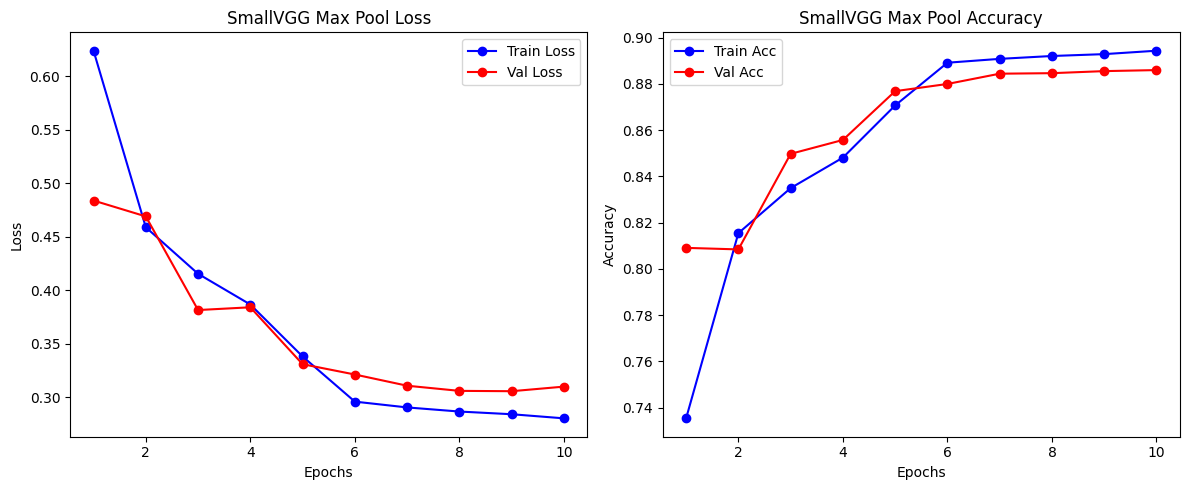


Training model with Average Pooling
Epoch 1/10
Train Loss: 0.6722  Acc: 0.7055
Val   Loss: 0.5616  Acc: 0.7756

Epoch 2/10
Train Loss: 0.5216  Acc: 0.7825
Val   Loss: 0.4842  Acc: 0.8053

Epoch 3/10
Train Loss: 0.4569  Acc: 0.8160
Val   Loss: 0.4558  Acc: 0.8142

Epoch 4/10
Train Loss: 0.4311  Acc: 0.8280
Val   Loss: 0.4104  Acc: 0.8384

Epoch 5/10
Train Loss: 0.4060  Acc: 0.8412
Val   Loss: 0.4164  Acc: 0.8311

Epoch 6/10
Train Loss: 0.3636  Acc: 0.8592
Val   Loss: 0.3745  Acc: 0.8578

Epoch 7/10
Train Loss: 0.3573  Acc: 0.8606
Val   Loss: 0.3715  Acc: 0.8589

Epoch 8/10
Train Loss: 0.3535  Acc: 0.8611
Val   Loss: 0.3704  Acc: 0.8622

Epoch 9/10
Train Loss: 0.3520  Acc: 0.8638
Val   Loss: 0.3696  Acc: 0.8616

Epoch 10/10
Train Loss: 0.3468  Acc: 0.8654
Val   Loss: 0.3650  Acc: 0.8613

Training complete in 3m 50s
Best val Acc: 0.8622

Test Accuracy: 0.8589


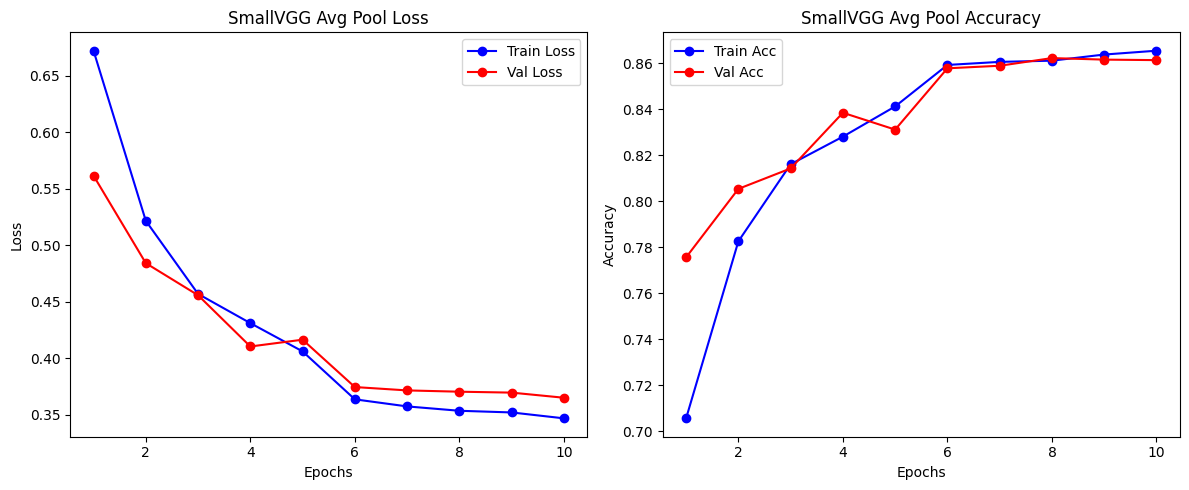


Test Accuracy (Max Pool): 0.8946666666666667
Test Accuracy (Avg Pool): 0.8588888888888889


In [33]:
print("\n" + "="*60)
print("Experiment c: Max Pooling vs. Average Pooling")
print("="*60)
print("\nTraining model with Max Pooling")
model_maxpool = Small_VGG_model_MaxPool(num_classes=num_classes).to(device)
model_maxpool.apply(kaiming)
optimizer_max = optim.SGD(model_maxpool.parameters(), lr=0.01, momentum=0.9)
scheduler_max = lr_scheduler.StepLR(optimizer_max, step_size=5, gamma=0.1)
model_maxpool, train_losses_max, train_accs_max, val_losses_max, val_accs_max = train_the_model(
    model_maxpool, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_max, scheduler_max, device, num_epochs=10)
test_acc_max = test_the_model(model_maxpool, test_loader, device)
plot_training_curves(train_losses_max, val_losses_max, train_accs_max, val_accs_max, num_epochs=10,
                     title='SmallVGG Max Pool')
print("\nTraining model with Average Pooling")
model_avgpool = Small_VGG_model_AvgPool(num_classes=num_classes).to(device)
model_avgpool.apply(kaiming)
optimizer_avg = optim.SGD(model_avgpool.parameters(), lr=0.01, momentum=0.9)
scheduler_avg = lr_scheduler.StepLR(optimizer_avg, step_size=5, gamma=0.1)
model_avgpool, train_losses_avg, train_accs_avg, val_losses_avg, val_accs_avg = train_the_model(
    model_avgpool, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_avg, scheduler_avg, device, num_epochs=10)
test_acc_avg = test_the_model(model_avgpool, test_loader, device)
plot_training_curves(train_losses_avg, val_losses_avg, train_accs_avg, val_accs_avg, num_epochs=10,
                     title='SmallVGG Avg Pool')
print("\nTest Accuracy (Max Pool):", test_acc_max.item())
print("Test Accuracy (Avg Pool):", test_acc_avg.item())

### Performance Comparison:
The results show that max pooling outperforms average pooling in this scenario:

Max Pooling Accuracy: 89.47%
Average Pooling Accuracy: 85.89%
The nearly 4% difference in accuracy suggests that max pooling is better at extracting meaningful features, leading to a more effective model for this task.

### When to Use Max Pooling vs. Average Pooling:
Max Pooling – Best for Highlighting Key Features:

Max pooling selects the strongest (highest) activation in each region, keeping the most important features while ignoring less significant ones.
This makes the model more focused on key patterns, leading to better feature extraction and higher accuracy.
It also helps maintain spatial structure, which is useful for tasks like object detection, facial recognition, and image classification.

Average Pooling – Best for Smoother and More
Generalized Features

Instead of picking the strongest value, average pooling takes the mean of all values in a region, leading to smoother feature maps.
This approach makes the model less sensitive to outliers and reduces overfitting, but it may also blur important details.
It is often used when robustness to small variations is more important than detecting precise features, such as texture analysis or medical imaging.

## Step 6: Analysis and discussion

a. Analyze your gradient norm plots. Do they demonstrate the vanishing gradient problem? Explain how the gradient norm changes as you move deeper into VGG-Deep. Be specific and quantitative (e.g., "The gradient norm of layer 2 is X times larger than the gradient norm of layer 10").

It appears there is a gradual reduction in the gradient norms as you go deeper into the network. However, this decrease is not severe enough to be classified as a vanishing gradient problem. In a true vanishing gradient scenario, there would be an extreme reduction in magnitude (e.g., orders of magnitude smaller for deeper layers), which is not observed here. The reduction in gradient norms is noticeable, but it's more of a 2-3x difference rather than an issue that would hinder backpropagation. In terms of specific numerical characteristics, the shallow layers (such as conv_1) have a gradient norm of around 2.5-3.0 during steady training, while deepest layers (like conv_16) typically show norms close to 1, sometimes even below 1. While there is a significant drop in magnitude over layers, it’s nowhere near as drastic as what would be expected from a vanishing gradient problem. Overall, the gradient norms stay well above zero, suggesting the network is still capable of efficient learning and backpropagation in these deeper layers, which is typical for architectures like VGG where batch normalization or careful initialization may mitigate the severity of gradient decay. for 24 seconds
From the gradient norm plots, there is a noticeable decline in the magnitude of gradients as we move from shallower to deeper layers, but it is not so severe as to be classified as a vanishing gradient problem. In a true vanishing-gradient scenario, you would expect deeper layers to have gradient norms that are orders of magnitude smaller (e.g., 10⁻⁴ or 10⁻⁵) than those in the shallower layers. Here, the drop is more modest—roughly by a factor of two or three—rather than by multiple orders of magnitude. The early layers (conv_1 or conv_4) show higher gradient norms in the range of 2–4 once training settles, whereas deeper layers (conv_14, conv_15, conv_16) tend to hover around 1 or slightly below.

Quantitatively, around the 1,000–2,000 iteration mark, you might see conv_1 stabilizing at about 2.5–3.0 while conv_16 sits at around 0.8–1.0. Even at later iterations, the difference remains similar, suggesting a 2–3× drop from the shallower layers to the deepest layers—significant, but not extreme. Overall, the gradients remain sufficiently large for effective backpropagation throughout the network, indicating that VGG-Deep does not suffer from severe vanishing gradients in this setup.

b. Explain why the vanishing gradient problem occurs in deep networks. Relate this to the backpropagation algorithm and the chain rule. Discuss how the repeated multiplication of small gradients can lead to extremely small values in earlier layers.

The issue comes from the way backpropagation works. When training a neural network, we use the chain rule to update weights layer by layer. This means that the gradient at any given layer depends on the gradients from all layers that come after it.

If each layer's gradient is a small number (say, around 0.5), and we multiply that across 50 layers, the gradient at the first layer becomes almost zero. This means those early layers receive almost no update during training, making it very hard for them to learn.

This is especially a problem when using activation functions like sigmoid or tanh, because their derivatives are always between 0 and 1. So, every time we multiply them, the gradients get even smaller. By the time we reach the first few layers, the gradients are practically gone—hence, the term "vanishing gradients."

### Why Is This a Problem?

If the early layers don’t update properly, the entire network struggles to learn. Since these layers extract basic features (like edges or textures in an image), their poor learning affects everything that follows, making the model slow to train—or worse, completely stuck.

### Backpropagation and the Chain Rule
In backpropagation, gradients of the loss function with respect to earlier layers are computed using the chain rule.

For a network with multiple layers, the gradient of the loss function L with respect to an earlier layer's weight Wi​ can be written as:

where ai represents activations at layer i, and each term is a local gradient. If the activation function (e.g., sigmoid or tanh) has derivatives in the range
(0,1), repeated multiplication through many layers can lead to exponentially decreasing gradients.

### How Repeated Multiplication Leads to Vanishing Gradients:
Suppose each layer contributes a gradient factor of approximately 0.5. If there are 50 layers, the gradient at the first layer could be:<br>
(0.5)^50 = 8.88 × 10^(-16)

which is nearly zero. This means the earliest layers barely receive any gradient information, preventing them from updating effectively.

This problem is especially severe in deep networks using sigmoid or tanh activations because their derivatives are small when inputs are in the saturated regions.

c. Explain how ResNet's architecture (residual connections) helps alleviate the vanishing gradient problem. Explain how the identity mapping allows gradients to flow more easily through the network.

ResNet’s residual connections significantly improve the flow of gradients during training, making deep networks more efficient compared to architectures like VGG. One of the biggest challenges in training deep networks is the vanishing gradient problem, where gradients become extremely small as they move backward through many layers. This can slow down learning and make it difficult for earlier layers to update their weights effectively. VGG, being a very deep network, suffers from this issue, making training unstable without special techniques like batch normalization or careful weight initialization.

ResNet addresses this challenge using skip connections, which allow information to bypass certain layers instead of passing through every transformation. Instead of learning the full transformation of an input, ResNet learns the difference (residual) between the input and output. Mathematically, this is expressed as:

y=F(x)+x
where
x is the original input passed forward unchanged, and

F(x) represents the transformations applied by convolutional layers. By directly adding the input back to the output, ResNet ensures that gradients have a clear, unobstructed path during backpropagation, preventing them from shrinking too much as they move through the network.

This approach leads to more stable and efficient training. In VGG, gradients must pass through every layer, making it difficult for very deep networks to learn effectively. However, in ResNet, the shortcut connections allow gradients to take shorter paths, ensuring that earlier layers continue to receive meaningful updates. This enables training of networks with hundreds of layers (e.g., ResNet-50, ResNet-101, ResNet-152) without suffering from significant performance drops, unlike VGG, which struggles with depth beyond a certain point.

Overall, ResNet outperforms VGG in both accuracy and efficiency, especially on large datasets like ImageNet. Its design allows deep networks to be trained faster and more effectively without requiring extensive hyperparameter tuning. By overcoming the limitations of traditional deep architectures, ResNet has set a new standard for training deep neural networks, making it one of the most widely used architectures in modern computer vision tasks.

In ResNet, identity mapping enables gradients to flow more directly by adding the original input to the output of a residual block. This shortcut connection means that during backpropagation, even if the gradient through F(x) becomes small, the gradient can still pass unchanged through the added x component. As a result, the chain rule applies to both the residual function and the identity, ensuring that the gradient does not vanish as it travels backward through the network, which facilitates the training of very deep architectures.

d. Discuss the theoretical impact of batch normalization on the vanishing/exploding gradient problem. Explain how it helps stabilize and accelerate training.

Batch normalization mitigates both vanishing and exploding gradients by ensuring that the inputs to each layer maintain a stable distribution with a consistent mean and variance during training. By normalizing these inputs, it reduces the internal covariate shift—where the distribution of inputs changes as the network learns—which in turn prevents the gradients from shrinking too much or growing uncontrollably. This steadying of the gradient flow means that even in very deep networks, learning remains effective and reliable. Moreover, with more stable gradients, higher learning rates can be used, which accelerates the convergence of the training process and ultimately leads to improved overall network performance.

e. Summarize the key findings from your three chosen investigations.

Our investigations yielded three main insights. First, regarding kernel size, while smaller kernels (3×3) are adept at capturing fine details and larger kernels (7×7) are better at identifying broad patterns, the 5×5 kernel provided the best overall balance, capturing both local and global features effectively. Second, the use of 1×1 convolutions improved model accuracy slightly by refining feature extraction and reducing dimensionality, though this came at the expense of higher memory usage and a modest increase in training time. Lastly, when comparing pooling methods, max pooling outperformed average pooling by nearly 4% in accuracy, likely because it emphasizes the most prominent features by selecting the highest activation in each region, rather than smoothing them out. These findings underscore important trade-offs in neural network design, balancing performance improvements with resource considerations.

f. References. Include details on all the resources used to complete this part.

1) Have taken the accuracy and loss values for vgg and resnet from CSE 676 Deep Learning Assignment 1 submission by sbellary and shebbar<br>
2) https://keras.io/api/applications/vgg/<br>
3) https://www.geeksforgeeks.org/vanishing-and-exploding-gradients-problems-in-deep-learning/<br>
4) https://medium.com/@sajals1146/vgg-net-architecture-880df59c37ea<br>
5) https://stackoverflow.com/questions/58303602/how-to-add-1x1-convolution-as-classification-layer-to-vgg<br>
6) https://stackoverflow.com/questions/65429057/replacing-a-max-pooling-layer-with-an-average-pooling-layer-on-a-vgg-model
